In [11]:
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from dmba import plotDecisionTree, classificationSummary, regressionSummary

%matplotlib inline
import matplotlib.pylab as plt

Colab environment detected.


In [10]:
!pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 34.8 MB/s eta 0:00:00


In [13]:
#reading the data
bank_df = pd.read_csv('bank.csv')

In [14]:
#finding the shape
bank_df.shape

(11162, 17)

In [15]:
#finding the null values if any
bank_df.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
deposit      False
dtype: bool

In [16]:
#displaying top 5
bank_df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [17]:
#drop contact column
bank_df = bank_df.drop(columns=['contact'])

In [18]:
#finding if any outliers are present
numeric_columns = bank_df.select_dtypes(include=[np.number])
outliers = bank_df[(numeric_columns < numeric_columns.min() - 3 * (numeric_columns.max() - numeric_columns.min())) | (numeric_columns > numeric_columns.max() + 3 * (numeric_columns.max() - numeric_columns.min()))].dropna()
outliers

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,deposit


In [19]:
bank_df['deposit'].value_counts()['yes']

5289

In [20]:
bank_df['deposit'].value_counts()['no']

5873

In [21]:
bank_df = pd.get_dummies(bank_df, columns=['job','marital','education','default','housing','loan','month','poutcome'],drop_first=True)

In [22]:
bank_df.head(3)

,age,balance,day,duration,campaign,pdays,previous,deposit,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,2343,5,1042,1,-1,0,yes,False,False,...,False,False,False,True,False,False,False,False,False,True
1,56,45,5,1467,1,-1,0,yes,False,False,...,False,False,False,True,False,False,False,False,False,True
2,41,1270,5,1389,1,-1,0,yes,False,False,...,False,False,False,True,False,False,False,False,False,True


In [23]:
# Develop predictors X and output variable Y for the data set.
X = bank_df.drop(columns=['deposit'])
y = bank_df['deposit']

# Develop training (60%) and validation(40% or 0.4) partitions for
# UniversalBank data frame.
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

Classes: no, yes

Classification Tree


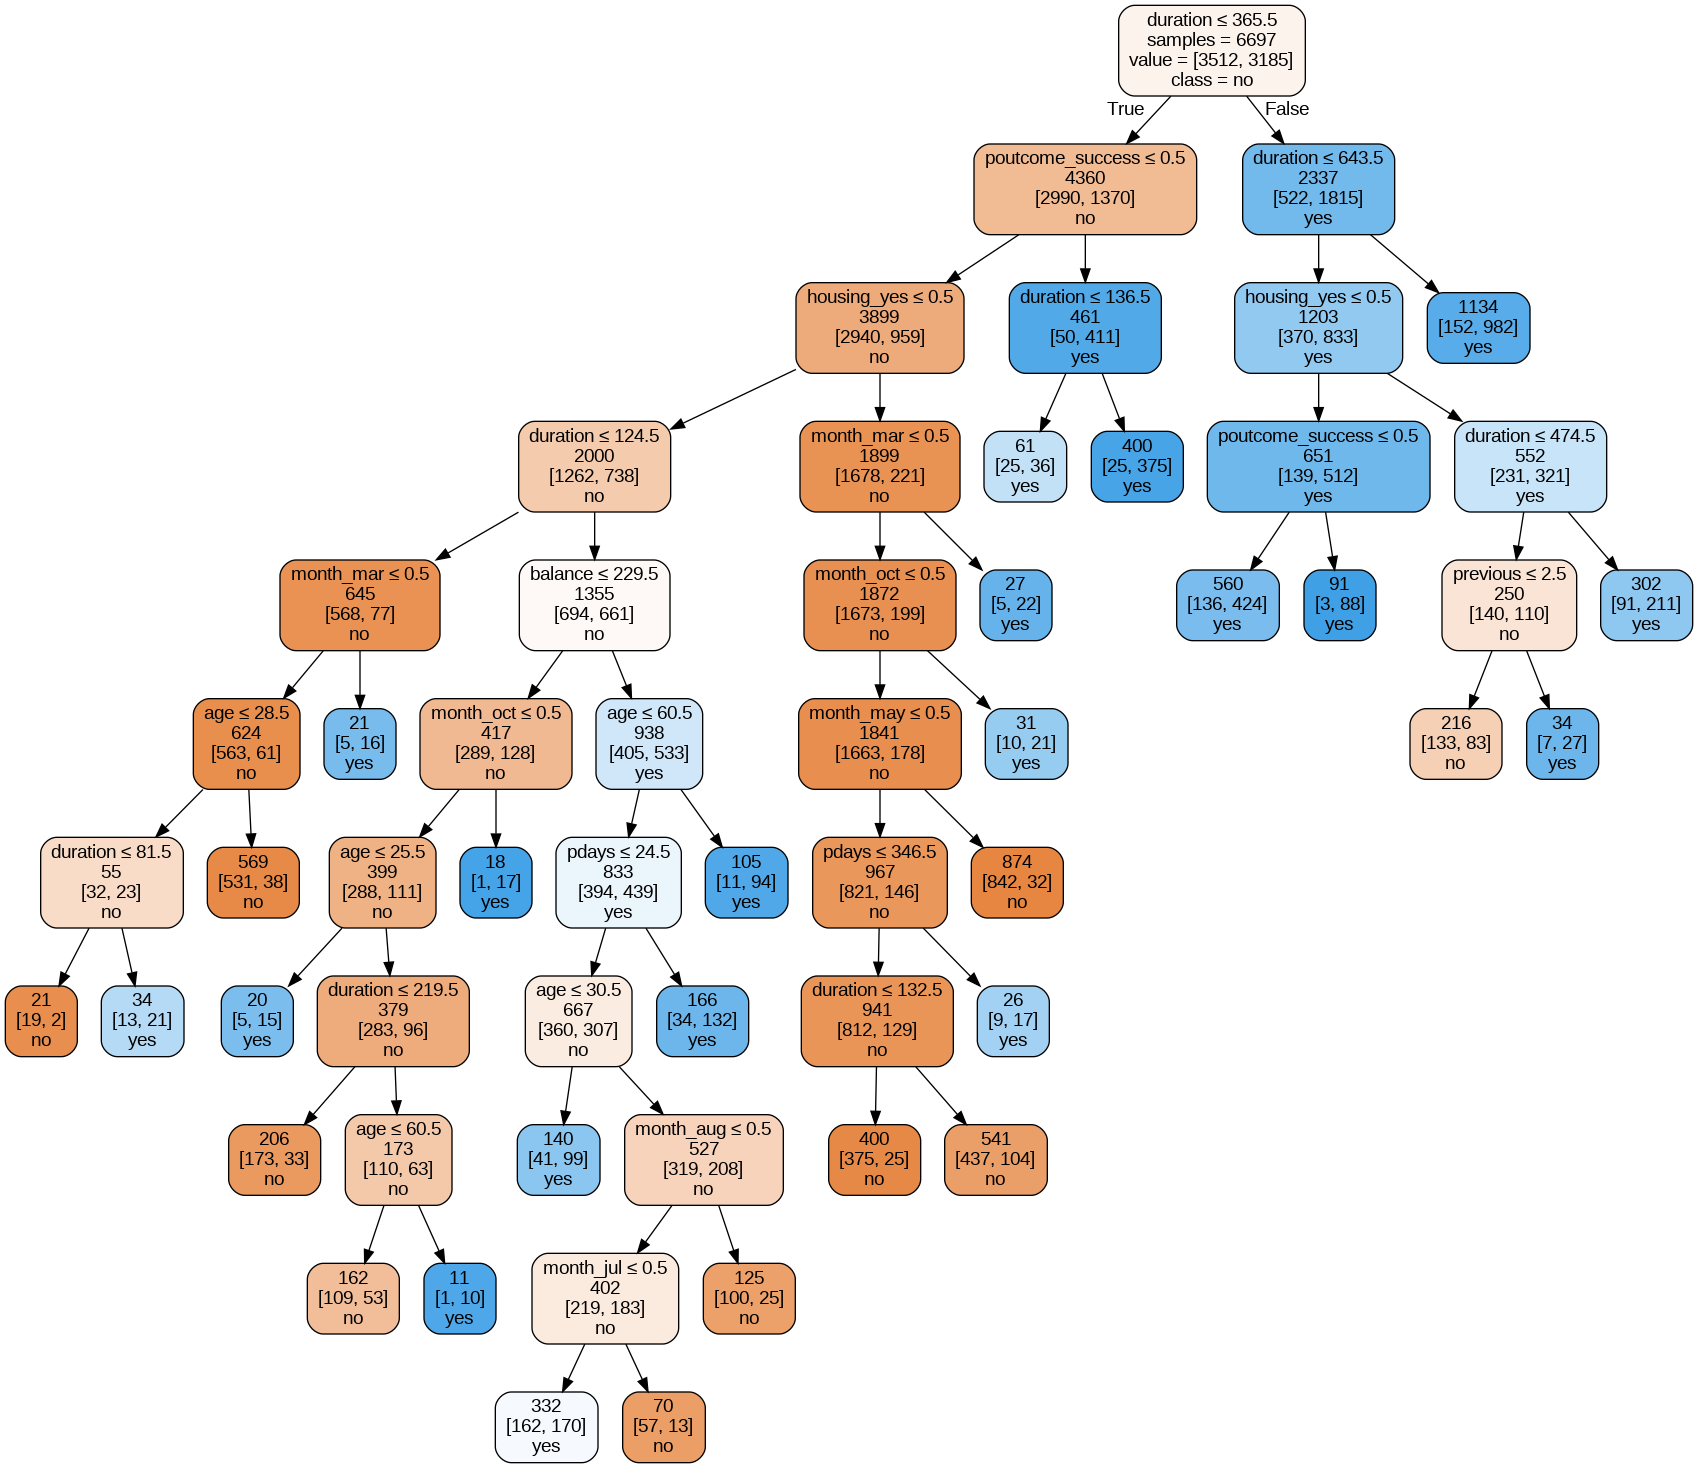

In [24]:
# Develop a classification tree using training partition.
bank_tree = DecisionTreeClassifier(max_depth=10,
                min_impurity_decrease=0.001, min_samples_split=30)
bank_tree.fit(train_X, train_y)

# Display classes used in the classification tree: 'fraud' and 'legitimate'.
#print("Classes: {}".format(', '.join(fraud_tree.classes_)))
print("Classes: {}".format(', '.join(map(str, bank_tree.classes_))))

# Use plotDecisionTree() function to visualize the classfication tree.

print()
print('Classification Tree')
plotDecisionTree(bank_tree, feature_names=train_X.columns, class_names=bank_tree.classes_)

In [25]:
# Confusion matrices for full classification tree.

# Identify  and display confusion matrix for training partition.
print('Training Partition for Smaller Tree')
classificationSummary(train_y, bank_tree.predict(train_X))

# Identify  and display confusion matrix for validation partition.
print()
print('Validation Partition for Smaller Tree')
classificationSummary(valid_y, bank_tree.predict(valid_X))

Training Partition for Smaller Tree
Confusion Matrix (Accuracy 0.8292)

       Prediction
Actual    0    1
     0 2776  736
     1  408 2777

Validation Partition for Smaller Tree
Confusion Matrix (Accuracy 0.8056)

       Prediction
Actual    0    1
     0 1805  556
     1  312 1792


In [27]:
# Applying RandomForestClassifier() function to develop a combined classification tree using Random Forest algorithm.
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

# Display number of nodes in Random Forest trees.
n_nodes = rf.estimators_[0].tree_.node_count
print('Number of Nodes in Tree in Random Forest:', n_nodes)

Number of Nodes in Tree in Random Forest: 2355


In [28]:
# Confusion matrices for Random Forest classification.

# display confusion matrix for training partition.
print('Training Partition for Random Forests')
classificationSummary(train_y, rf.predict(train_X))

# display confusion matrix for validation partition.
print()
print('Validation Partition for Random Forests')
classificationSummary(valid_y, rf.predict(valid_X))

Training Partition for Random Forests
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 3512    0
     1    0 3185

Validation Partition for Random Forests
Confusion Matrix (Accuracy 0.8374)

       Prediction
Actual    0    1
     0 1900  461
     1  265 1839


In [29]:
# For Random Forest, identify variable importance scores.
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Develop data frame for variable importance. The table data is sorted
# in descending order (ascending=False).
score_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': importances, 'Std': std})
score_df = score_df.sort_values('Importance', ascending=False)

# Display variable importance for Random Forest results.
print('Variable Importance Scores for Random Forest')
print(score_df)

Variable Importance Scores for Random Forest
                Feature  Importance       Std
3              duration    0.338841  0.026429
0                   age    0.089958  0.012523
1               balance    0.087821  0.011287
2                   day    0.073875  0.008945
5                 pdays    0.038790  0.023276
4              campaign    0.037697  0.005953
38     poutcome_success    0.036342  0.026014
24          housing_yes    0.030238  0.009960
6              previous    0.023364  0.020198
33            month_may    0.017351  0.006725
32            month_mar    0.014180  0.004819
35            month_oct    0.013037  0.004642
39     poutcome_unknown    0.011974  0.017499
18      marital_married    0.011747  0.003139
20  education_secondary    0.011261  0.002651
21   education_tertiary    0.010943  0.002707
30            month_jul    0.010716  0.003298
26            month_aug    0.010695  0.002989
25             loan_yes    0.010607  0.002909
19       marital_single    0.010233